In [28]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import matplotlib.pyplot as plt

In [29]:
# Versuchen Daten einzulesen
try:
    processed_df = pd.read_csv('../data/processed_complaints.csv')
    print("Datei gefunden.")
    print(f"Geladene Texte: {len(processed_df)}")
except FileNotFoundError:
    print("Fehler: Datei 'processed_complaints.csv' nicht gefunden. Zuerst 1. Datenvorverarbeitung ausführen")

Datei gefunden.
Geladene Texte: 66806


In [30]:
texts = processed_df['processed_text'].dropna().tolist()

In [31]:
# TF-IDF Vektorisierung einleiten/erstellen
tfidf_vectorizer = TfidfVectorizer(
    max_features = 1000, # die 1000 Häufigsten Themen | Vielleicht höher stellen
    min_df = 5,          # Begriffe müssen in mindestens 5 Dokumenten vorkommen
    max_df= 0.85,        # Begriffe, die mehr als 85% der Dokumente vorkommen
)

In [32]:
# Vektorisierung durchführen
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
print(f"TF-IDF-Matrix erstellt mit Shape: {tfidf_matrix.shape}")
print("Beispielbegriffe:", list(tfidf_vectorizer.get_feature_names_out()[:10]))

TF-IDF-Matrix erstellt mit Shape: (66805, 1000)
Beispielbegriffe: ['ability', 'able', 'absolutely', 'accept', 'accepted', 'access', 'according', 'account', 'acct', 'accurate']


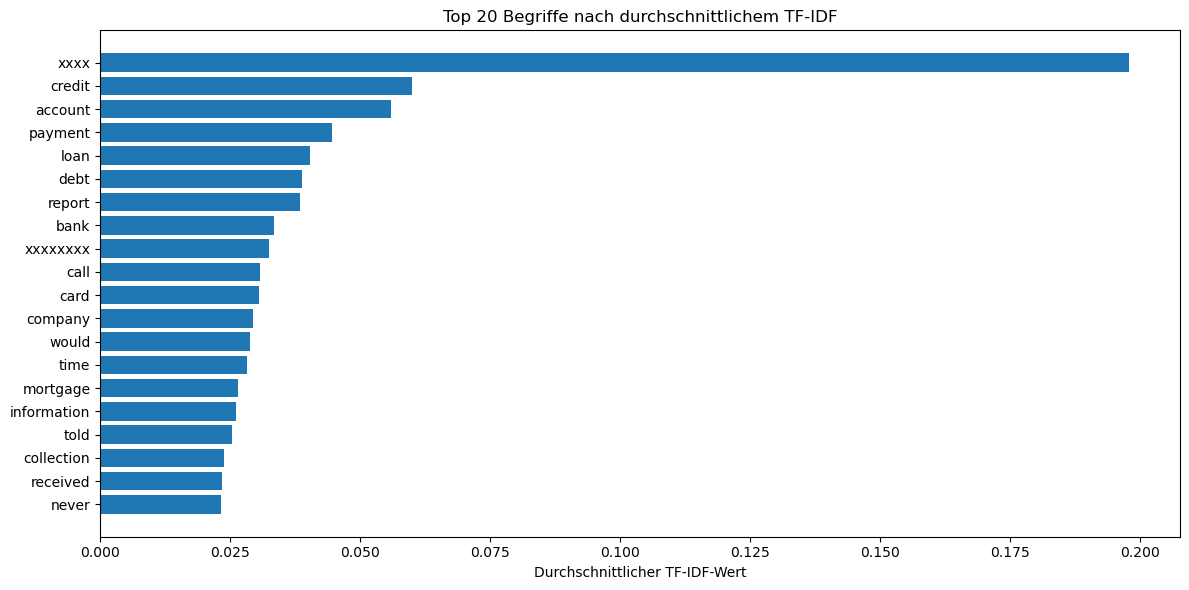

In [35]:
# Mittelwert je Spalte (= Begriff) berechnen
tfidf_means = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

# Begriffe holen
terms = tfidf_vectorizer.get_feature_names_out()

# Top 20 Begriffe mit höchstem durchschnittlichen TF-IDF-Wert
top_n = 20
top_indices = tfidf_means.argsort()[::-1][:top_n]
top_terms = [terms[i] for i in top_indices]
top_scores = [tfidf_means[i] for i in top_indices]

# Balkendiagramm erstellen
plt.figure(figsize=(12, 6))
plt.barh(top_terms[::-1], top_scores[::-1])  # Umdrehen für höchste oben
plt.xlabel("Durchschnittlicher TF-IDF-Wert")
plt.title("Top 20 Begriffe nach durchschnittlichem TF-IDF")
plt.tight_layout()
plt.show()

In [ ]:
# Hier stellen wir fest das xxxx, vielleicht ein Platzhalter ist, der keine inhaltliche Bedeutung hat. Daher werde ich diese auch noch entfernen
